In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Load population dataset

In [2]:
def parse_population_data(path):
    """Parse population data from csv file and return a dataframe
    """
    df = pd.read_excel(path)
    
    # Drop the first 15 rows and set the first row as the header
    df = df.iloc[15:]
    
    # Set the first row as the header
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    # Select the columns of interest
    df = df[['Region, subregion, country or area *', 'ISO3 Alpha-code', 'Year', 'Total Population, as of 1 January (thousands)', 'Life Expectancy at Birth, both sexes (years)']]
    
    return df

df_pop = parse_population_data('dataset\WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx')  # Source: https://population.un.org/wpp/Download/Standard/MostUsed/

# Load Powerty and Inequality Platform dataset

In [3]:
def parse_pip(path):
    """Parse the PIP dataset to a dataframe"""
    df = pd.read_csv(path)
    
    # Keep only national data (remove rural or urban only data)
    df = df[df['reporting_level'] == 'national']
    
    # Drop duplicates having welfare_type = "consumption"
    df = df[~((df[['country_name', 'country_code', 'reporting_year']].duplicated(keep=False)) &
              (df['welfare_type'] == "consumption"))
            ].reset_index(drop=True)
    
    # Keep only relevant columns and rename it
    df = df[['region_name', 'region_code', 'country_name', 'country_code', 'reporting_year', 'headcount']]
    df.rename(columns={'reporting_year':'year'}, inplace=True)

    return df
  
  
  # Load the population dataset. Source: https://pip.worldbank.org/
df_pip = parse_pip('dataset\pip.csv')

# Create a dataframe that links country to region
df_region_country = df_pip[['region_name','region_code','country_name','country_code']].drop_duplicates()

# Functions to get the share of population below 2.15$ a day

In [4]:
def get_share_of_population_below_2_15_a_day(df, df_pip):
    """Add the interpolated share of population below 2.15$ a day to the main dataframe"""

    df = df.merge(
        df_pip, 
        how='left', 
        on=['region_name', 'region_code', 'country_name', 'country_code', 'year'],
        validate='one_to_one'
        )

    df['share of population below 2.15$ a day'] = (
        df[['country_name', 'headcount']]
        .groupby('country_name')
        .transform(lambda x: x.interpolate(
            method='linear', 
            limit_area=None, 
            limit_direction='forward')
                   )
        )
    
    df.drop(columns=['headcount'], inplace=True)
    
    return df


def get_population_below_2_15_a_day(df, df_pop):
    """Add the interpolated population below 2.15$ a day to the main dataframe"""

    df['Total Population (thousands)'] = df.merge(
        df_pop.loc[~df_pop['ISO3 Alpha-code'].isna()],
        how='left',
        left_on=['country_code', 'year'],
        right_on=['ISO3 Alpha-code', 'Year'],
        validate='one_to_one'
        )['Total Population, as of 1 January (thousands)'].astype(float)

    df['population below 2.15$ a day (thousands)'] = df['share of population below 2.15$ a day'] * df['Total Population (thousands)']
    
    # df.drop(columns=['Total Population (thousands)'], inplace=True)
    
    return df


def set_plot_population_below_2_15_a_day(df):
    """Plot the population below 2.15$ a day for different regions and years"""
    
    sns.set_theme(style='darkgrid')

    # Grouping by region and year
    df_grouped = df.dropna().groupby(['region_name', 'year']).sum(numeric_only=True)
    df_grouped.reset_index(inplace=True)
    
    # Sum up all regions to get the world data
    complete_years = df_grouped.groupby('year').filter(lambda x: x['region_name'].nunique() == df['region_name'].nunique())
    df_world = complete_years.groupby('year').sum(numeric_only=True).reset_index()
    df_world['region_name'] = 'World'
    df_grouped = pd.concat([df_grouped, df_world])
    
    # Calculate the share of population below 2.15$ a day
    df_grouped['share of population below 2.15$ a day'] = df_grouped['population below 2.15$ a day (thousands)'] / df_grouped['Total Population (thousands)'] * 100
    
    # Plot the responses for different events and regions
    plot = sns.lineplot(x='year', y='share of population below 2.15$ a day',
                hue='region_name', data=df_grouped)
    plot.figure.set_size_inches(15, 8)
    plot.set_xlabel('Year', fontsize=12)
    plot.set_ylabel('Share of Population (%)', fontsize=12)
    plot.set_title('Share of Population Living Below 2.15$ a Day', fontsize=16)
    plot.legend(loc='upper left', frameon=True)
    plot.set_aspect('auto')
    plot.yaxis.set_major_formatter(mtick.PercentFormatter())
    return plot

# Plot the share of population below 2.15$ a day

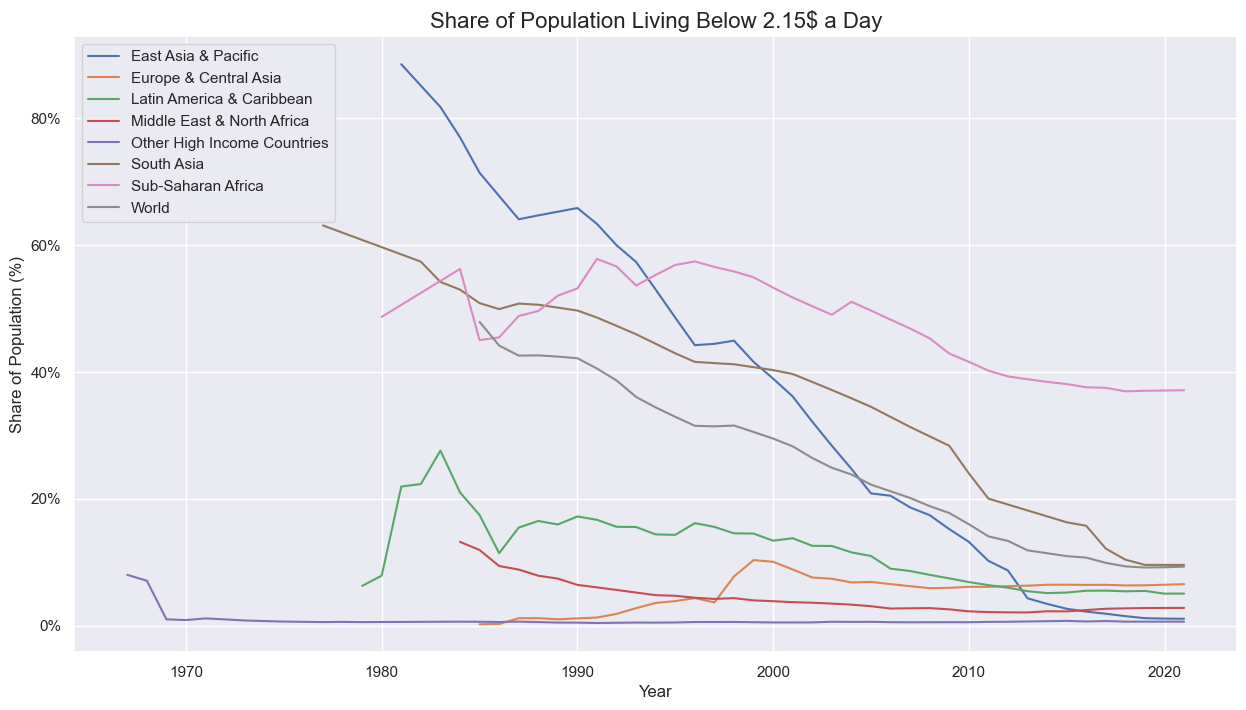

In [5]:
df = pd.DataFrame(columns=['region_name', 'region_code', 'country_name', 'country_code'])
for year in range(1900, 2023):
    df_ = df_region_country.copy()
    df_['year'] = year
    df = pd.concat([df, df_])
df['year'] = df['year'].astype(int)

df = get_share_of_population_below_2_15_a_day(df, df_pip)
df = get_population_below_2_15_a_day(df, df_pop)
_ = set_plot_population_below_2_15_a_day(df)

# Insights
- The graph reveals that all trends indicate a decrease. Despite this, approximately 10% of the population still lives in extreme poverty. In 1990, this number was above 40%. 
- The largest decrease in poverty is observed in Asia, which makes up the majority of the population and has seen a rapid reduction in poverty. China alone accounts for 70% of the decrease in poverty in the "East Asia & Pacific" region, with poverty in China dropping from 91% in 1981 to 0.14% in 2019.
- Africa presents difficulties in collecting data, with some countries lacking data for each year, leading to a flat trend after 2015 based on the most recent known data. 
- The apparent increase in poverty in "Europe & Central Asia" countries could be attributed to the limited data before 1995, with only 7 countries having data in 1991 and 25 countries in 1998.

Some notes about the methodology: In this study, the direct calculation of the mean value for each region was not performed as it would have resulted in small countries having the same significance as large countries. Instead, a weighted average was calculated taking into account the population of each country. However, this approach was limited by the absence of yearly data for each country. To address this issue, a linear interpolation was applied between two surveys. For extrapolation to recent years, the last known value was utilized, which constitutes a pessimistic assumption considering the clear trend of poverty reduction globally.

# Appendixes

In [6]:
# List the years where data were collected for each country in Europe & Central Asia
pd.set_option('display.max_colwidth', 100)
df_pip[df_pip['region_name'] == 'Europe & Central Asia'].groupby('country_name')['year'].apply(list)

country_name
Albania                                                    [1996, 2002, 2005, 2008, 2012, 2014, 2015, 2016, 2017, 2018, 2019]
Armenia                   [1996, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,...
Azerbaijan                                                                               [1995, 2001, 2002, 2003, 2004, 2005]
Belarus                   [1993, 1995, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,...
Bosnia and Herzegovina                                                                               [2001, 2004, 2007, 2011]
Bulgaria                  [1989, 1992, 1994, 1995, 1997, 2001, 2003, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,...
Croatia                   [1988, 1998, 1999, 2000, 2001, 2004, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,...
Czech Republic            [1992, 1993, 1996, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 

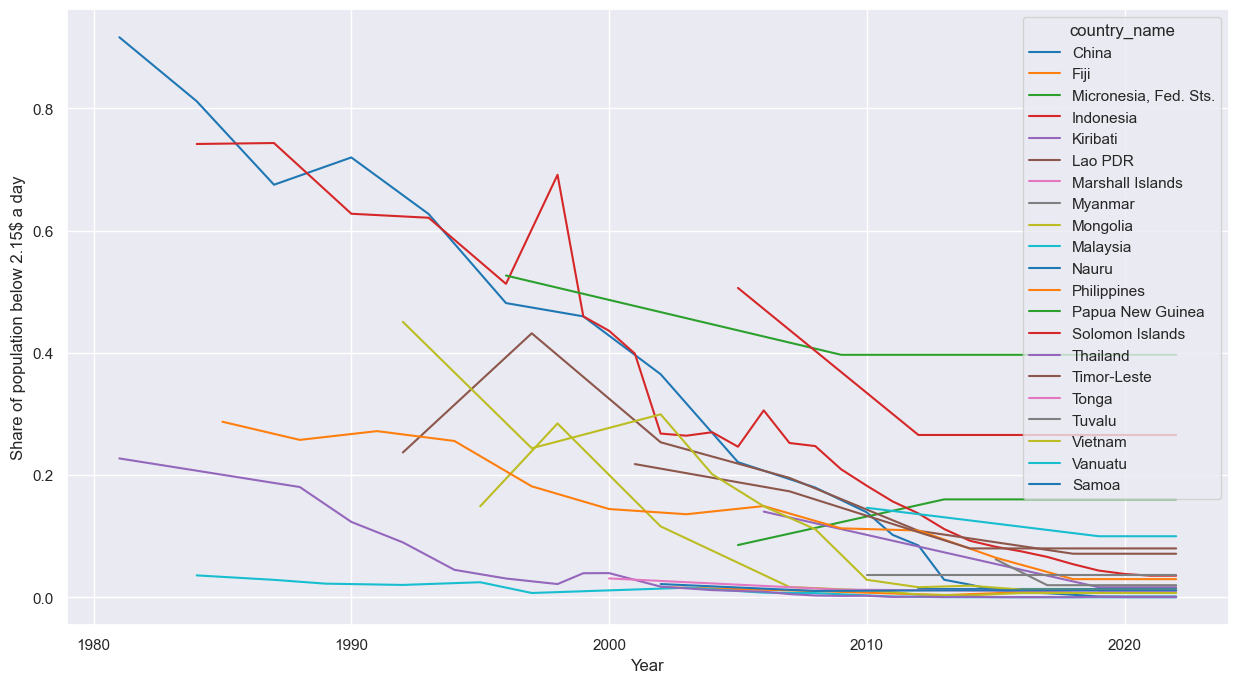

In [7]:
# Plot the share of population below 2.15$ a day for the region East Asia & Pacific
plot = sns.lineplot(x='year', y='share of population below 2.15$ a day', data=df[df['region_name'] == 'East Asia & Pacific'], hue='country_name', palette='tab10')
plot.figure.set_size_inches(15, 8)
plot.set_xlabel('Year', fontsize=12)
plot.set_ylabel('Share of population below 2.15$ a day', fontsize=12)
plot.set_aspect('auto')
plt.show()

In [8]:
# Share of the population living in China among the region "East Asia & Pacific"
(df[(df['country_name'] == 'China')].groupby('year').sum(numeric_only=True) / df[df['region_name'] == 'East Asia & Pacific'].groupby('year').sum(numeric_only=True) * 100)['Total Population (thousands)'].tail(30)

year
1993    72.239430
1994    72.071819
1995    71.900236
1996    71.724034
1997    71.535102
1998    71.342905
1999    71.154586
2000    70.976160
2001    70.821933
2002    70.662559
2003    70.503389
2004    70.347324
2005    70.204585
2006    70.061343
2007    69.922264
2008    69.783922
2009    69.657469
2010    69.533599
2011    69.411667
2012    69.282933
2013    69.176843
2014    69.061249
2015    68.957771
2016    68.834371
2017    68.724078
2018    68.621192
2019    68.481907
2020    68.332079
2021    68.159799
2022          NaN
Name: Total Population (thousands), dtype: float64

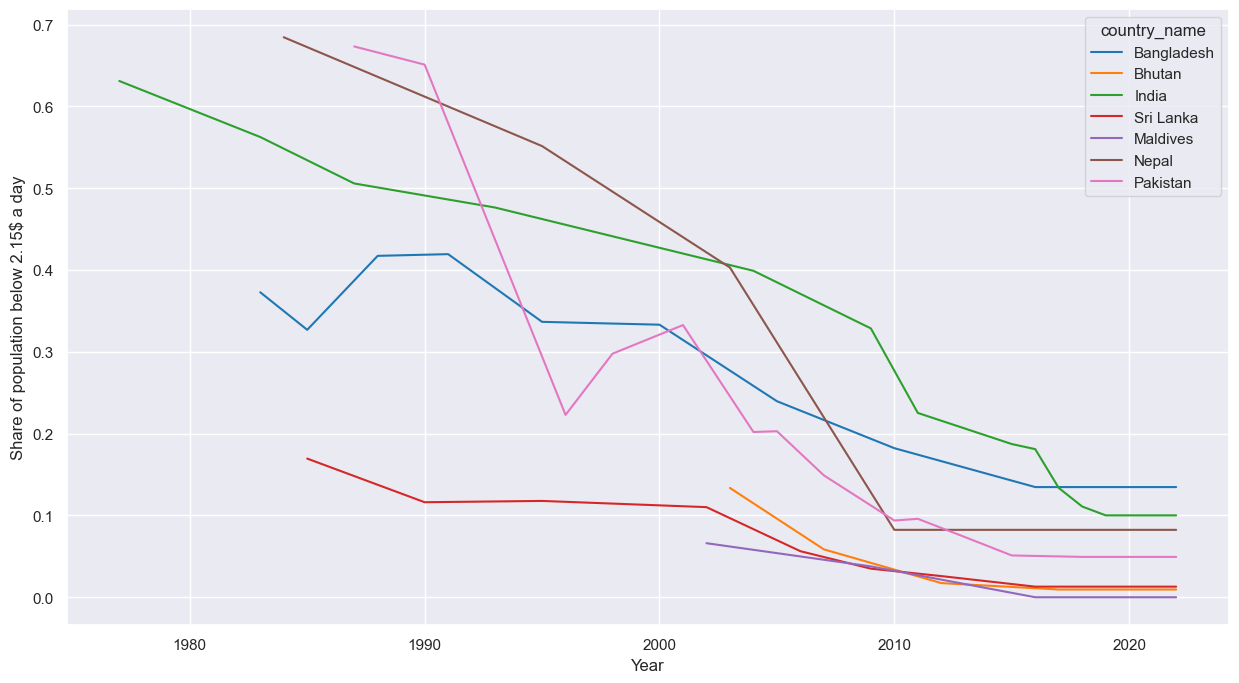

In [9]:
# Plot the share of population below 2.15$ a day for the region South Asia
plot = sns.lineplot(x='year', y='share of population below 2.15$ a day', data=df[df['region_name'] == 'South Asia'], hue='country_name', palette='tab10')
plot.figure.set_size_inches(15, 8)
plot.set_xlabel('Year', fontsize=12)
plot.set_ylabel('Share of population below 2.15$ a day', fontsize=12)
plot.set_aspect('auto')
plt.show()

Text(0.5, 1.0, 'Share of Population Living Below 2.15$ a Day (without China)')

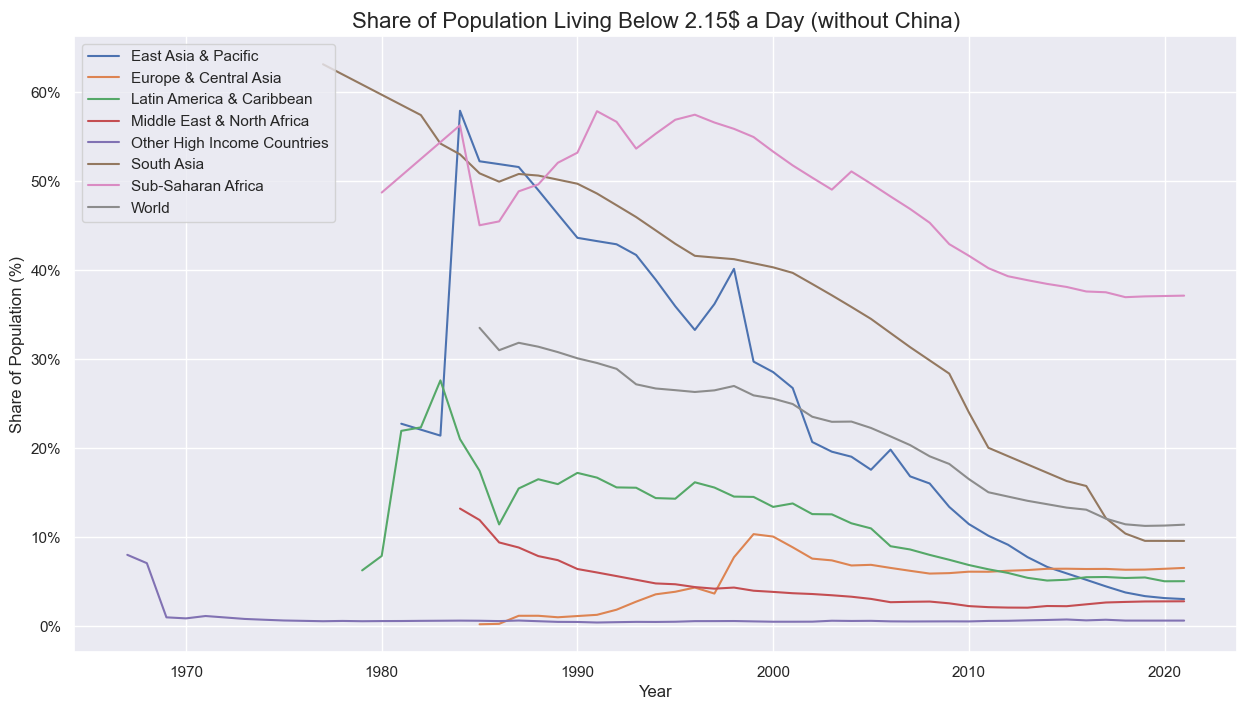

In [10]:

df_without_China = pd.DataFrame(columns=['region_name', 'region_code', 'country_name', 'country_code'])
for year in range(1900, 2023):
    df_ = df_region_country.copy()
    df_['year'] = year
    df_without_China = pd.concat([df_without_China, df_])
df_without_China['year'] = df_without_China['year'].astype(int)
df_without_China = df_without_China[df_without_China['country_name'] != 'China']

df_without_China = get_share_of_population_below_2_15_a_day(df_without_China, df_pip)
df_without_China = get_population_below_2_15_a_day(df_without_China, df_pop)
plot_population_below_2_15_a_day_without_China = set_plot_population_below_2_15_a_day(df_without_China)
plot_population_below_2_15_a_day_without_China.set_title('Share of Population Living Below 2.15$ a Day (without China)', fontsize=16)

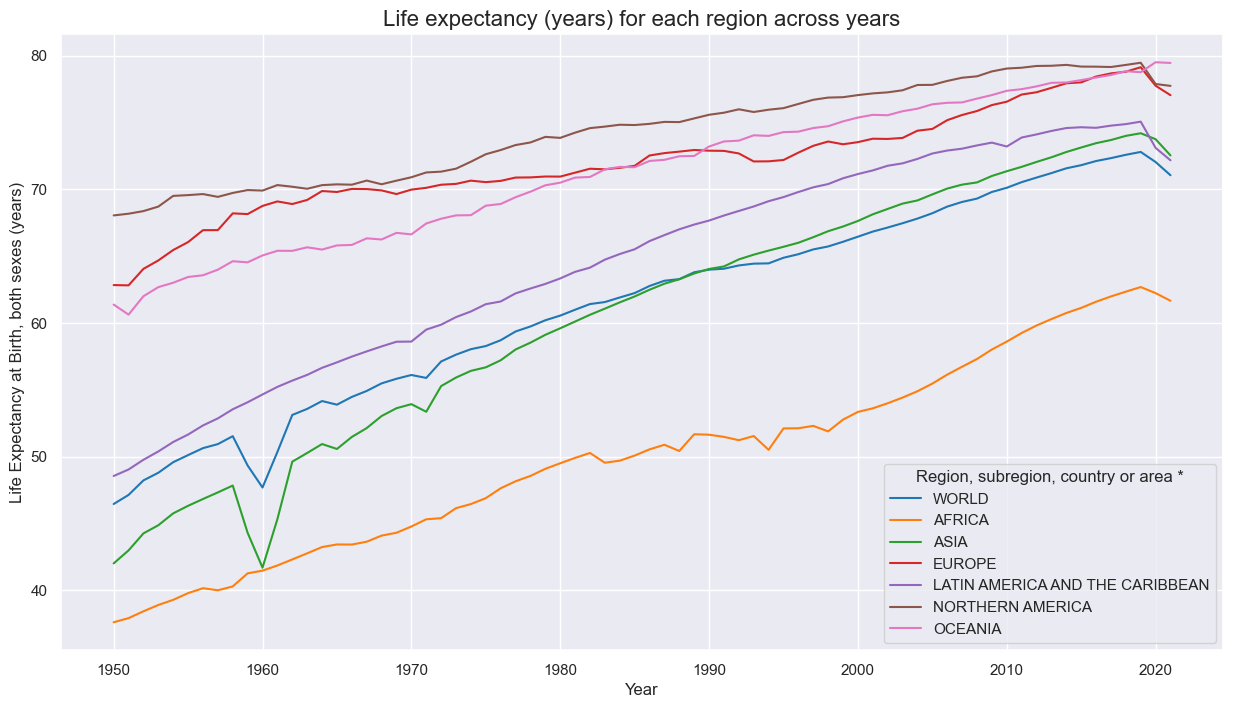

In [11]:
# Plot life expectancy for different regions
regions = [x for x in df_pop['Region, subregion, country or area *'].unique() if x.isupper()]
plot = sns.lineplot(x='Year', y='Life Expectancy at Birth, both sexes (years)', data=df_pop[df_pop['Region, subregion, country or area *'].isin(regions)], hue='Region, subregion, country or area *', palette='tab10')
plot.figure.set_size_inches(15, 8)
plot.set_aspect('auto')
plot.set_title('Life expectancy (years) for each region across years', fontsize=16)
plt.show()
